In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
from matplotlib.pyplot import hist

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [2]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [12]:
x = pd.read_stata("maindata.dta", convert_categoricals=False)
laws_csv = pd.read_csv("When_Were_Laws.csv")
laws_csv = laws_csv[np.logical_not(np.isnan(laws_csv["FIPS"]))]  # FIPS codes identify states
laws_csv = laws_csv.drop("State_Name", axis=1)  # Dropping as useless
laws_csv = laws_csv.rename({'FIPS': 'stfips'}, axis=1) 

# Merging
merged = pd.merge(laws_csv, x, on='stfips', how='outer')

In [5]:
basic_merged = merged.copy()  # To allow for re-running 

basic_merged = basic_merged[basic_merged["a_age"] <= 25]  # Can be changed later, but for now useful I think

# Dropping states who were treated < 97 (i.e. they always had programs)
# This is following Callaway + Sant'anna, as we cannot meaningfully 
# do any inference using those states. Although we can compare them later as a 
# robustness check, which may be interesting
basic_merged = basic_merged[basic_merged["Year_Implemented"].str.contains("always")==False]  

# Making it so that "never-treated" states are treated at T = infinity
basic_merged = basic_merged.replace("never", "1000000") 
basic_merged["Year_Implemented"] = basic_merged["Year_Implemented"].astype(int)  # converting to int

# Indicator for if the individual was treated (i.e. under 19 and in a state who added a law)
basic_merged["treatment"] = basic_merged["under19"] # * basic_merged["year_indic"]

# Generating list of confounders of interest, these are not necessarily optimal. 
list_of_confounders = ["year", "stfips", "fownu18", "faminctm1", "a_maritl", "female" , "fpovcut", "povll"]
list_of_confounders += ["anykids", "disability", "noemp_insured"]


In [6]:
def make_g_model():
  return RandomForestClassifier(n_estimators=100, max_depth=2)

In [7]:
def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions

In [42]:
#Calculating probability of being treated (under 19) while living in a state that implemented during that year 

def calculate_g(treated_year):
    sub_merged = basic_merged.copy()
    sub_merged = sub_merged[sub_merged["Year_Implemented"] == treated_year]
    sub_merged = sub_merged[sub_merged["year"] == treated_year]
    
    sub_merged = sub_merged.reset_index()
    
    confounders = sub_merged[["year","stfips", "fownu18", "faminctm1", "a_maritl", "female","fpovcut", "povll", "anykids", "disability", "noemp_insured"]]
    treatment = sub_merged['treatment']
    outcome = sub_merged['pubonly']
    g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)
    
    return g
    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

(array([0.89944592, 1.80545714, 2.54077059, 1.35901683, 0.87975002,
        0.89288062, 0.29543844, 0.89288062, 1.5034534 , 4.9699311 ]),
 array([0.12824966, 0.19059759, 0.25294552, 0.31529345, 0.37764138,
        0.43998931, 0.50233724, 0.56468517, 0.6270331 , 0.68938103,
        0.75172896]),
 <a list of 10 Patch objects>)

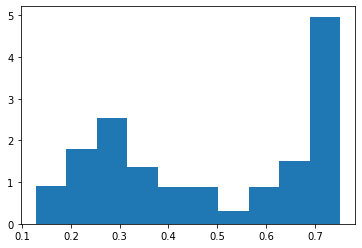

In [43]:
g1 = calculate_g(1997)
hist(g1, density=True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

(array([0.79035846, 2.60418286, 2.29659135, 1.25519407, 1.04277661,
        0.88277385, 0.20690012, 1.79727239, 0.77932379, 5.41526584]),
 array([0.12558885, 0.18416896, 0.24274908, 0.30132919, 0.3599093 ,
        0.41848942, 0.47706953, 0.53564965, 0.59422976, 0.65280988,
        0.71138999]),
 <a list of 10 Patch objects>)

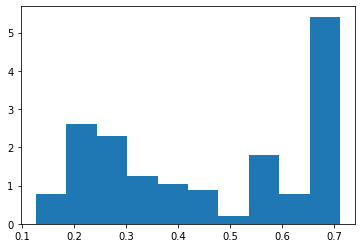

In [44]:
g2 = calculate_g(1998)
hist(g2, density=True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

(array([0.73608566, 3.02247464, 2.24937909, 0.71963682, 1.11852123,
        0.76487113, 0.21794715, 1.00749155, 1.36114164, 5.67485034]),
 array([0.13131499, 0.19058338, 0.24985178, 0.30912017, 0.36838856,
        0.42765696, 0.48692535, 0.54619375, 0.60546214, 0.66473053,
        0.72399893]),
 <a list of 10 Patch objects>)

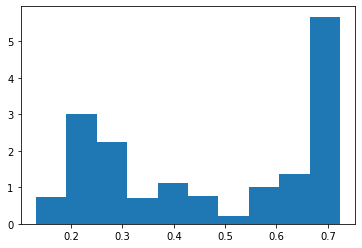

In [45]:
g3 = calculate_g(1999)
hist(g3, density=True)

In [37]:
sub_merged = basic_merged.copy()
sub_merged = sub_merged[sub_merged['year'] == 1997]
sub_merged["year_indic"] = (sub_merged["Year_Implemented"] == 1997)
sub_merged["treatment"] = sub_merged["under19"] * sub_merged["year_indic"]

In [40]:
#during year 1997, probability of both being under 19 and living in a state that passed the law in 1997
sub_merged = sub_merged.reset_index()
    
confounders = sub_merged[["fownu18", "faminctm1", "a_maritl", "female","fpovcut", "povll", "anykids", "disability", "noemp_insured"]]
treatment = sub_merged['treatment']
outcome = sub_merged['pubonly']
g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

(array([ 6.32079608, 20.27099055, 11.9749457 ,  9.6910643 ,  9.48119412,
         2.70979441,  1.52464515, 12.27740566,  8.07382937, 36.77049047]),
 array([0.01427787, 0.02267451, 0.03107116, 0.03946781, 0.04786446,
        0.0562611 , 0.06465775, 0.0730544 , 0.08145104, 0.08984769,
        0.09824434]),
 <a list of 10 Patch objects>)

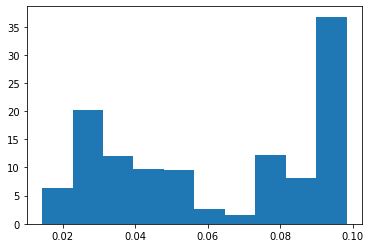

In [41]:
hist(g, density=True)